In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
first_row_measurement = session.query(Measurement).first()
first_row_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1fde386f4e0>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [11]:
first_row_station = session.query(Station).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1fde388f278>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [13]:
# Calculate the date 1 year ago from the last data point in the database
date = dt.date(2017,8,23) - dt.timedelta(days=365)
print(date)

2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date).order_by(Measurement.date).all()

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
percipitation_df = pd.DataFrame(results, columns = ["Date", "Percipitation"])
percipitation_df.set_index('Date')
percipitation_df = percipitation_df.dropna()
dates = percipitation_df["Date"]
percipitation = percipitation_df["Percipitation"]

In [16]:
# Sort the dataframe by date
percipitation_df.sort_values('Date').head()

,Date,Percipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
4,2016-08-23,0.02
5,2016-08-23,1.79


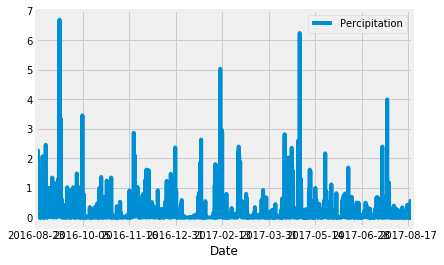

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
percipitation_df.plot("Date", "Percipitation")
plt.show()

![precipitation](Images/precipitation.png)

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
percipitation_df.describe()

,Percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [19]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).order_by(Station.station).count()
stations

9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activity_result = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

activity_result

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp = session.query(func.min(Measurement.tobs)).\
filter_by(station = "USC00519281").all()
highest_temp = session.query(func.max(Measurement.tobs)).\
filter_by(station = "USC00519281").all()
ave_temp = session.query(func.avg(Measurement.tobs)).\
filter_by(station = "USC00519281").all()
print(f'Lowest Temperature: {lowest_temp}, Highest Temperature: {highest_temp}, Average Temperature: {ave_temp}')

Lowest Temperature: [(54.0,)], Highest Temperature: [(85.0,)], Average Temperature: [(71.66378066378067,)]


In [22]:
# Choose the station with the highest number of temperature observations.
observations = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).first()
observations

('USC00519281', 54.0, 85.0, 71.66378066378067)

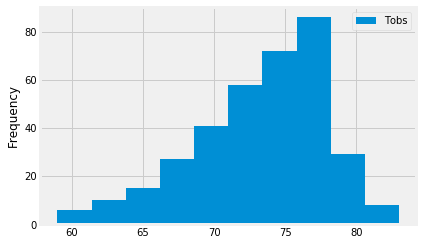

In [23]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last12mo_observation = session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.station == "USC00519281").filter(Measurement.date >= date).all()
last12mo_observation_df = pd.DataFrame(last12mo_observation, columns=["Date", "Tobs"])
last12mo_observation_df.plot.hist()


![precipitation](Images/station-histogram.png)

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_obv = calc_temps('2017-01-01', '2018-01-01')
print(trip_obv)

[(58.0, 74.14387974230493, 87.0)]


Text(0.5, 0, 'Average Temperature')

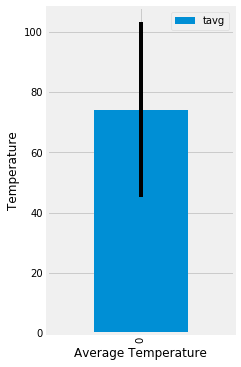

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_obv_df = pd.DataFrame(trip_obv, columns = ["tmin", 'tavg', 'tmax'])
tavg = trip_obv_df["tavg"]
tmin = trip_obv_df["tmin"]
tmax = trip_obv_df["tmax"]

fig, ax = plt.subplots(1,1)
trip_obv_df.plot.bar(y = 'tavg', yerr = (tmax-tmin), ax = ax, figsize = (3, 6))
ax.set_ylabel('Temperature')
ax.set_xlabel("Average Temperature")

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp]

total_rainfall = session.query(*sel).filter(Measurement.date >= date).group_by(Measurement.station).\
order_by(func.sum(Measurement.prcp).desc()).filter(Measurement.station == Station.station).all()

total_rainfall_df = pd.DataFrame(total_rainfall, columns=["Station", "Station Name", "Latitude", "Longigtude", "Elevation",
                                                          "Prcp"])
total_rainfall_df

,Station,Station Name,Latitude,Longigtude,Elevation,Prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.70
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.79
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.15
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.02
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.05
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip


In [ ]:
# push each tuple of calculations into a list called `normals`


normals

In [ ]:
# Set the start and end date of the trip


In [ ]:
# Use the start and end date to create a range of dates

In [ ]:
# Stip off the year and save a list of %m-%d strings

In [ ]:
# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index



In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
